<a href="https://colab.research.google.com/github/Dishant8127/Customer-Churn-Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import shap
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression

In [35]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)
df.head()

Path to dataset files: /kaggle/input/telco-customer-churn


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [36]:
  df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [37]:
df['Churn'].value_counts()

,count
Churn,
No,5174
Yes,1869


In [38]:
# Convert 'TotalCharges' to numeric, coerce errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipython-input-38-2244381434.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [39]:
# Drop customerID as it's not useful for prediction and impute missing values using KNN for any remaining missing values
df = df.drop('customerID', axis=1)
imputer = KNNImputer(n_neighbors=5)
df_imputed = pd.DataFrame(imputer.fit_transform(df.select_dtypes(include=[np.number])), columns=df.select_dtypes(include=[np.number]).columns)

In [40]:
# Create new features based on existing ones
df_imputed['LongTermCustomer'] = np.where(df_imputed['tenure'] > 60, 1, 0)
df_imputed['HighSpender'] = np.where(df_imputed['MonthlyCharges'] > 100, 1, 0)
df_imputed['ChurnRate'] = df_imputed['MonthlyCharges'] / df_imputed['TotalCharges']

In [41]:
# Encode target variable 'Churn' to 1 and 0
df_imputed['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [42]:
# Check if 'customerID' exists in the dataset and drop it
if 'customerID' in df_imputed.columns:
    df_imputed.drop('customerID', axis=1, inplace=True)
else:
    print("customerID column not found in the dataset.")

customerID column not found in the dataset.


In [43]:
# One-hot encode categorical variables
cat_cols = df_imputed.select_dtypes(include=['object']).columns
df_imputed = pd.get_dummies(df_imputed, columns=cat_cols, drop_first=True)

In [44]:
#  Split data into features and target
X = df_imputed.drop('Churn', axis=1)
y = df_imputed['Churn']


In [45]:
# Split into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [46]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [47]:
# Model - Logistic Regression, Random Forest, XGBoost
log_reg_model = LogisticRegression(max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)


In [48]:
# Combine models into a Voting Classifier
ensemble_model = VotingClassifier(estimators=[
    ('lr', log_reg_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
], voting='soft')

In [49]:
# Hyperparameter Tuning using GridSearchCV (Random Forest)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [50]:
# Train the Ensemble Model with the best Random Forest model
ensemble_model.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            f...,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')

In [51]:
# Evaluate the model
y_pred = ensemble_model.predict(X_test_scaled)
y_proba = ensemble_model.predict_proba(X_test_scaled)[:, 1]

In [52]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.48      0.54       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.77      0.79      0.78      1409

Confusion Matrix:
 [[930 105]
 [196 178]]
ROC AUC Score: 0.8156539822780232


In [53]:
# Plot ROC Curve with Plotly (Interactive)
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_curve_plot = go.Figure()
roc_curve_plot.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='Ensemble Model'))
roc_curve_plot.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'), name='Random'))
roc_curve_plot.update_layout(title="ROC Curve", xaxis_title="False Positive Rate", yaxis_title="True Positive Rate")
roc_curve_plot.show()

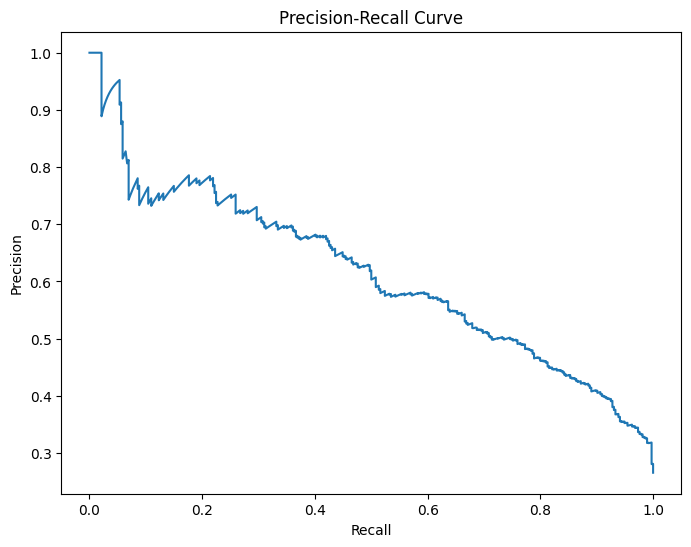

In [54]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

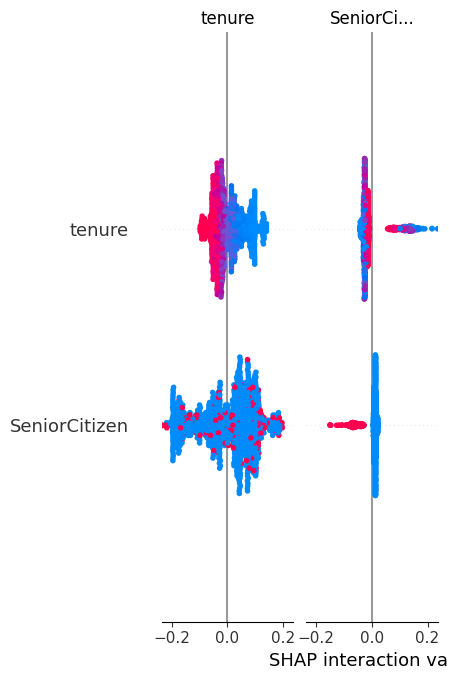

In [56]:
# Feature Importance with SHAP (Interactive)
# TreeExplainer does not support VotingClassifier, so we will use the best Random Forest model from the GridSearch
# Train the rf_model with the best parameters found by GridSearchCV
best_rf_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test_scaled)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

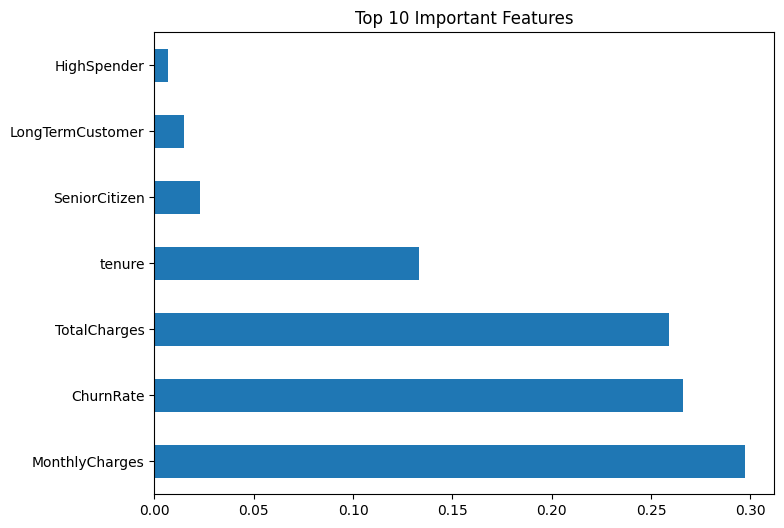

In [57]:
# Feature Importance Visualization
coef = pd.Series(ensemble_model.named_estimators_['rf'].feature_importances_, index=X.columns)
top_features = coef.abs().sort_values(ascending=False).head(10)
plt.figure(figsize=(8,6))
top_features.plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

In [58]:
# Create Feature Importance Dashboard with Plotly
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': coef
})

fig = px.bar(feature_importance, x='Importance', y='Feature', orientation='h', title="Feature Importance")
fig.show()